In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils import class_weight
import numpy as np
import os
import warnings
import pydot as pyd
import seaborn as sns
import pandas as pd
from timeit import default_timer as timer
import matplotlib.pyplot as plt

warnings.simplefilter(action = 'ignore', category = FutureWarning)

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID";

# GPUid to use
os.environ["CUDA_VISIBLE_DEVICES"] = "0";

# Allow growth of GPU memory, otherwise it will always look like all the memory is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2022-04-12 12:35:20.089820: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
2022-04-12 12:35:21.606146: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-12 12:35:21.606741: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-04-12 12:35:21.621579: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-12 12:35:21.621760: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce RTX 2080 Ti computeCapability: 7.5
coreClock: 1.65GHz coreCount: 68 deviceMemorySize: 10.76GiB deviceMemoryBandwidth: 573.69GiB/s
2022-04-12 12:35:21.621776: I tensorflow/stream_executor/platform

In [2]:
physical_devices # WIN

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
# Insert initial parameters
batch_size = 64
img_height, img_width = 224, 224
n_classes = 3

# Data augmentation
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   vertical_flip = True,
                                   brightness_range = [0.5, 1.25],
                                   rotation_range = 45,
                                   fill_mode = 'constant',
                                   samplewise_center = True,
                                   rescale = 1./255)
#                                    preprocessing_function = preprocess_input)
test_datagen = ImageDataGenerator(horizontal_flip = False, 
                                  vertical_flip = False,
                                  rotation_range = 0,
                                  samplewise_center = True,
                                  rescale = 1./255)
#                                   preprocessing_function = preprocess_input)

train = train_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_sagittal/train', 
                                          classes = ['G2','G3','G4'], color_mode = 'rgb', 
                                          class_mode = 'categorical', 
                                          target_size = (img_height, img_width), 
                                          batch_size = batch_size, seed = 123)
validation = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_sagittal/val', 
                                              classes = ['G2','G3','G4'], color_mode = 'rgb',
                                              class_mode = 'categorical', 
                                              target_size = (img_height, img_width), 
                                              batch_size = batch_size, seed = 123)
test = test_datagen.flow_from_directory('/local/data1/elech646/Tumor_grade_classification/dataset224_t1ce_sagittal/test', 
                                        classes = ['G2','G3','G4'], color_mode = 'rgb',
                                        shuffle = False, class_mode = 'categorical', 
                                        target_size = (img_height, img_width), 
                                        batch_size = batch_size)

Found 4525 images belonging to 3 classes.
Found 1105 images belonging to 3 classes.
Found 430 images belonging to 3 classes.


In [25]:
# Use class weights
class_weights = class_weight.compute_class_weight(class_weight = 'balanced', 
                                                  classes = np.unique(train.classes), 
                                                  y = train.classes)

# Convert to dictionary
class_weights = dict(enumerate(class_weights))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(64, 224, 224, 3) (64, 3)
-0.28399095


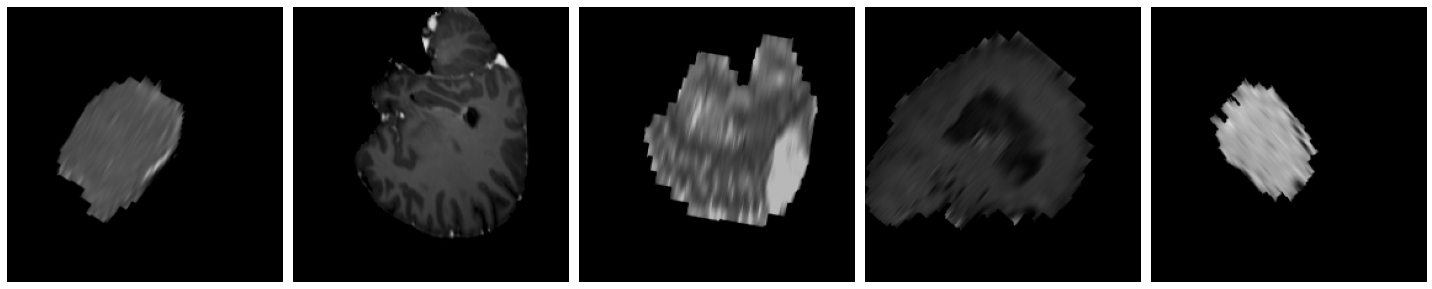

In [26]:
x_train, y_train = next(iter(train))
print(x_train.shape, y_train.shape)
print(x_train.min())

# Plot the images for fun
def plot_images(images):
    fig, axes = plt.subplots(1, 5, figsize = (20, 20))
    axes = axes.flatten()
    for img, ax in enumerate(axes):
        ax.imshow(images[img,:,:], cmap = 'gray')
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
plot_images(x_train[:1000])

In [27]:
# Load base model
resnet_50 = ResNet50(input_shape = (224, 224, 3), weights = 'imagenet', include_top = False)

freeze_until_layer = 100

# Freeze all layers before the `freeze_until_layer` layer
for layer in resnet_50.layers[:-freeze_until_layer]:
    layer.trainable = False

x = resnet_50.output
x = Flatten()(x)
x = Dense(10, activation = 'relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(n_classes, activation = 'softmax')(x)

model = Model(inputs = resnet_50.input, outputs = predictions)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

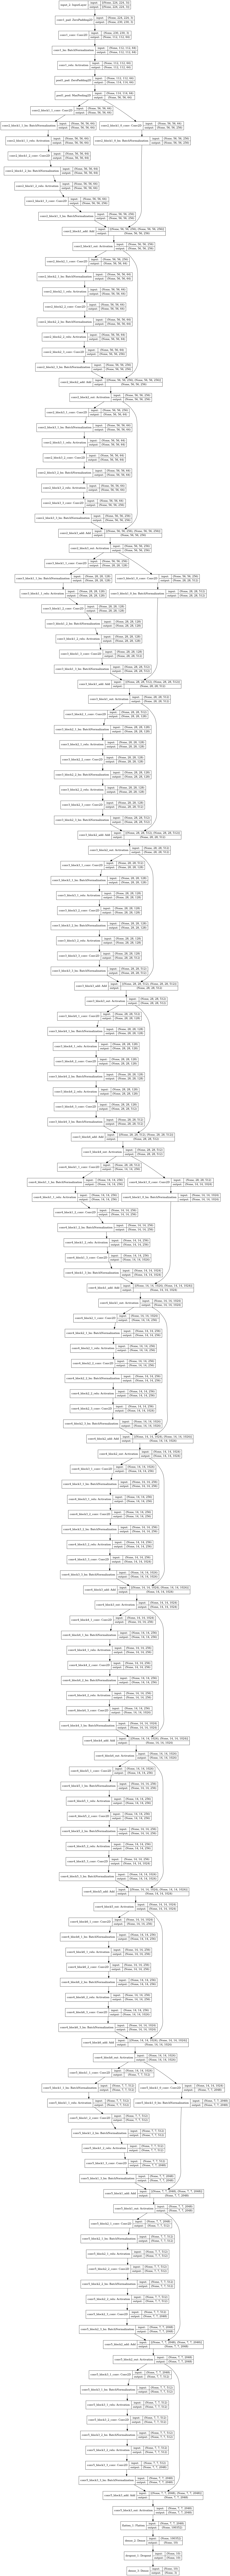

In [28]:
plot_model(model, to_file = 'resnet50_plot_t1ce_sagittal_3rd.png', show_shapes = True, show_layer_names = True)

In [30]:
# Save best model
checkpoint_path = '/local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_sagittal_3rd.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath = checkpoint_path,
                                                monitor = 'val_accuracy',
                                                mode = 'max',
                                                verbose = 1,
                                                save_best_only = True)

# Save log for history
# append: True: append if file exists (useful for continuing training)//False: overwrite existing file
csv_logger = CSVLogger('/local/data1/elech646/code/train_logs/resnet50_transfer_history_t1ce_sagittal_3rd.log', 
                       separator = ',', append = True)

# Reduce learning rate if val_accuracy is not improving
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', factor = 0.1,
                              patience = 5, min_lr = 0.000001)
es = EarlyStopping(monitor = 'val_accuracy', verbose = 1, 
                   patience = 15)

In [31]:
# Compile model
model.compile(Adam(lr = 1e-5),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

epochs = 35
start = timer()

history = model.fit(train, steps_per_epoch = len(train.labels) // batch_size, verbose = 1,
                    epochs = epochs, validation_data = validation,
                    validation_steps = len(validation.labels) // batch_size,
                    callbacks = [es, reduce_lr, checkpoint, csv_logger])

end = timer()
print("Training time: %.2f s\n" % (end - start))

Epoch 1/35
70/70 [==============================] - 37s 497ms/step - loss: 1.1279 - accuracy: 0.3869 - val_loss: 1.0697 - val_accuracy: 0.4715

Epoch 00001: val_accuracy improved from -inf to 0.47151, saving model to /local/data1/elech646/code/train_logs/resnet50_transfer_t1ce_sagittal_3rd.h5
Epoch 2/35
70/70 [==============================] - 34s 488ms/step - loss: 1.0313 - accuracy: 0.4674 - val_loss: 1.1703 - val_accuracy: 0.2592

Epoch 00002: val_accuracy did not improve from 0.47151
Epoch 3/35
70/70 [==============================] - 34s 487ms/step - loss: 1.0302 - accuracy: 0.4844 - val_loss: 1.0991 - val_accuracy: 0.4274

Epoch 00003: val_accuracy did not improve from 0.47151
Epoch 4/35
70/70 [==============================] - 34s 490ms/step - loss: 0.9720 - accuracy: 0.5196 - val_loss: 1.0850 - val_accuracy: 0.4017

Epoch 00004: val_accuracy did not improve from 0.47151
Epoch 5/35
70/70 [==============================] - 34s 488ms/step - loss: 0.9327 - accuracy: 0.5433 - val_lo

1st training:  

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(10, activation = 'relu')(x)
        x = Dropout(0.2)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64 (could increase here)

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 328.25 s $\approx 5$ min

test accuracy: 0.5885 (overfit)

------------------------------------------------------------------------------------------------------------------

2nd training:

froze bottom 100 layers instead

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(10, activation = 'relu')(x)
        x = Dropout(0.2)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64

number of epochs = 35

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 487.18 s $\approx 8$ min

test accuracy: 0.6615 (overfit)

------------------------------------------------------------------------------------------------------------------

3rd training:

froze bottom 100 layers
augmentation: horizontal+vertical flipping, 45 degree rotation, fill_mode = 'constant', brightness

Setup: `x = resnet_50.output
        x = Flatten()(x)
        x = Dense(10, activation = 'relu')(x)
        x = Dropout(0.2)(x)
        predictions = Dense(n_classes, activation = 'softmax')(x)`
       
batch size = 64

number of epochs = 35 (could squeeze more)

learning rate = 1e-5 with `ReduceLROnPlateau` + `EarlyStopping`

training time: 1236.24 s $\approx 20$ min

test accuracy: 0.7552 JESUS YES

In [32]:
score = model.evaluate(test, steps = len(test.labels) // batch_size, verbose = 0)
print('Test loss: %.4f' % score[0])
print('Test accuracy: %.4f' % score[1])

Test loss: 0.7249
Test accuracy: 0.7552


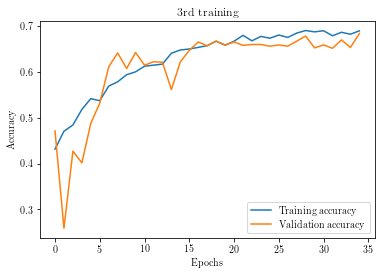

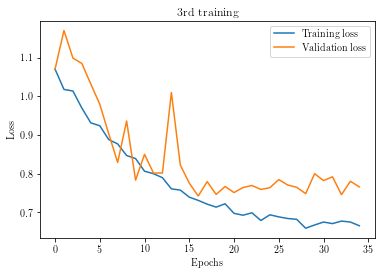

In [33]:
# Plot training + validation accuracy per epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
n_epochs = range(len(acc))

# for fancy LaTeX style plots
from matplotlib import rc
import matplotlib.pylab as plt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex = True)

# Plot accuracy
plt.plot(n_epochs, acc, label = 'Training accuracy')
plt.plot(n_epochs, val_acc, label = 'Validation accuracy')
plt.title('3rd training')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc = 'best')
plt.savefig('ResNet50_3rd_training_t1ce_sagittal_acc.png', dpi = 300)
plt.show()

# Plot loss
plt.plot(n_epochs, loss, label = 'Training loss')
plt.plot(n_epochs, val_loss, label = 'Validation loss')
plt.title('3rd training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc = 'best')
plt.savefig('ResNet50_3rd_training_t1ce_sagittal_loss.png', dpi = 300)
plt.show()

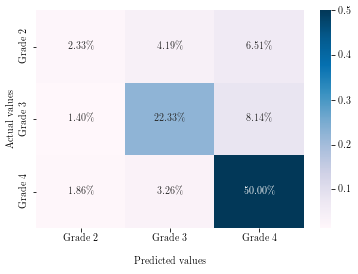

In [34]:
# Get true labels
y_true = test.classes

# Get rounded predictions
y_pred = np.argmax(model.predict(test), axis = 1) 

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)

#ax = sns.heatmap(cm, annot = True, cmap = 'Blues')
ax = sns.heatmap(cm / np.sum(cm), annot = True, fmt = '.2%', cmap = 'PuBu')
for t in ax.texts: 
    t.set_text(t.get_text().replace('%', '\%'))
ax.set_xlabel('\nPredicted values')
ax.set_ylabel('Actual values ');
# list must be in alphabetical order
ax.xaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
ax.yaxis.set_ticklabels(['Grade 2','Grade 3', 'Grade 4'])
plt.savefig('3rd_Training_CM_t1ce_sagittal.png', dpi = 300)
plt.show()

In [35]:
# Print classification report
print(classification_report(y_true, y_pred))

# Save the classification report
clsf_report = pd.DataFrame(classification_report(y_true = y_true, y_pred = y_pred, output_dict = True)).transpose()
clsf_report.to_csv('Classification Report-3rd Training on t1ce sagittal.csv', index = True)

              precision    recall  f1-score   support

           0       0.42      0.18      0.25        56
           1       0.75      0.70      0.72       137
           2       0.77      0.91      0.83       237

    accuracy                           0.75       430
   macro avg       0.65      0.60      0.60       430
weighted avg       0.72      0.75      0.72       430

